# Tasks
1. From V_in, R, and C generate V_out
1. From V_out generate I_out
1. From V_out and I_out generate Z
1. Match Z with R and C

In [724]:
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

In [725]:
import panel as pn
import param
pn.extension(sizing_mode="stretch_width", throttled=True)

In [726]:
import session_info
session_info.show()

## Device and Circuit Settings

In [727]:
# Frequency & Amplitude of sin wave
freq = 1000
V_amp = 3.3 / 2

# Desired number of wave oscillations
cycle_num = 2

# Duration of sin wave in seconds
duration = cycle_num / freq 

# Sampling rate of device (samples / sec)
samp_rate = freq * 100

# Input voltage wave
samp_num = int(duration * samp_rate)
t = np.arange(0, duration, duration / samp_num)
V_in = V_amp * np.sin(freq*(2*np.pi*t))

# Resistance in Ohms
R = 100

# Capacitance in Farads
nC = 1000
C = nC * 1e-9

# Ground value of circuit
V_g = 1.65

# Variable resistor of device
Rf = 1000

# Impedance of RC series
w = 2*np.pi*freq
Z = complex(R, -1/(w*C))

# Output current wave

phase = np.angle(- (V_amp / Z))
I_amp = V_amp / abs(Z)

I_out = I_amp * np.sin(freq*(2*np.pi*t) + phase)


# Output voltage wave
V_out = V_in - I_out * Rf
V_out[V_out > 12] = 12
V_out[V_out < -12] = -12

In [728]:
np.max(I_out)

0.008778208673876535

In [729]:
print("Device parameters:")
print(f"{Rf=}")
print(f"{V_g=}")
print(f"{samp_rate=}")

print("\nWave parameters:")
print(f"{freq=}")
print(f"{V_amp=}")
print(f"{cycle_num=}")
print(f"{duration=}")

print("\nCircuit parameters:")
print(f"{R=}")
print(f"{C=}")
print(f"{Z=}")
print(f"{phase=}")
print(f"{Rf=}")

Device parameters:
Rf=1000
V_g=1.65
samp_rate=100000

Wave parameters:
freq=1000
V_amp=1.65
cycle_num=2
duration=0.002

Circuit parameters:
R=100
C=1.0000000000000002e-06
Z=(100-159.15494309189532j)
phase=-2.1317784429035203
Rf=1000


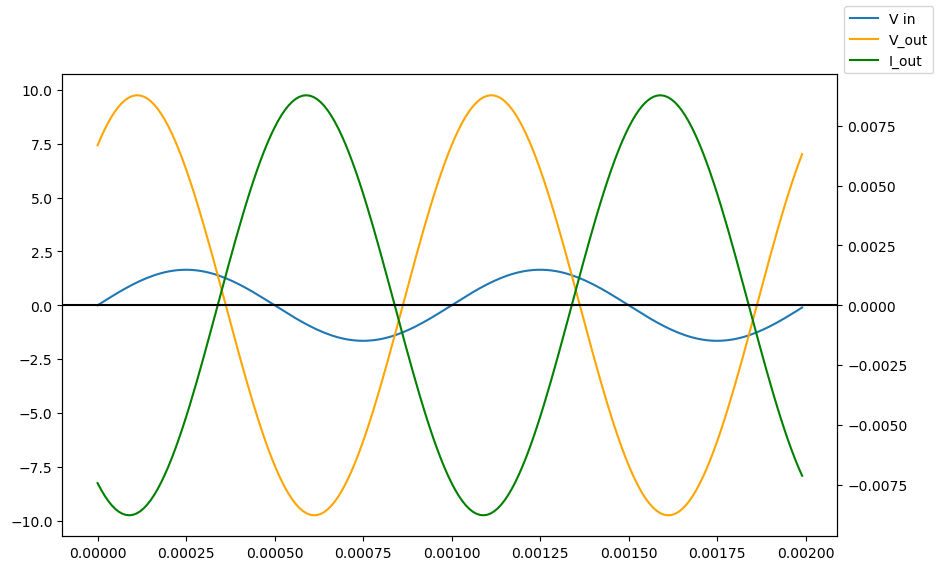

In [730]:
# Plot V_in, I_out, and V_out
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
ax.plot(t, V_in, label="V in")
ax.plot(t, V_out, color='orange', label="V_out")
ax2.plot(t, I_out, color='Green', label="I_out")
plt.axhline(y=0, color='black')
fig.legend()

V_in_amp=1.6500000000000001
(3.653518250609944e-16-1.6500000000000001j)


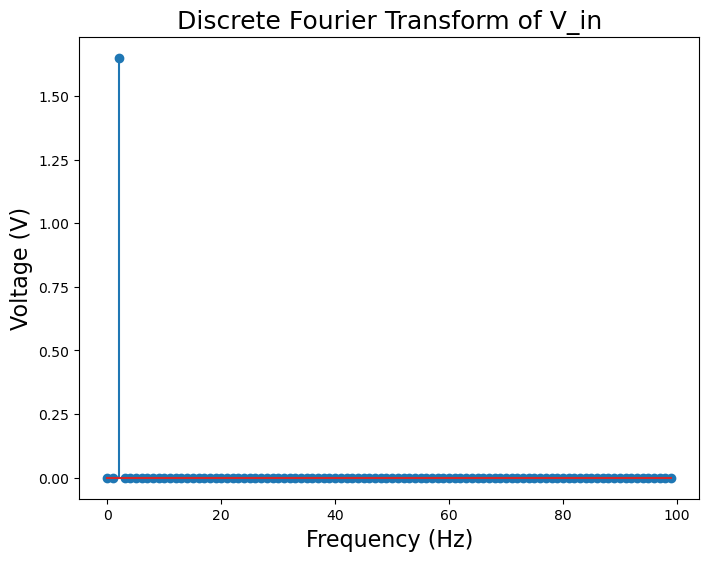

In [732]:
V_in_fft = 2 * np.fft.fft(V_in) / len(V_in)
V_in_fft = V_in_fft[:len(V_in_fft)//2]

V_in_amp = np.max(abs(V_in_fft))
V_crit = np.argmax(abs(V_in_fft))


plt.figure(figsize=(8,6))
plt.title("Discrete Fourier Transform of V_in", size=18)
plt.xlabel("Frequency (Hz)", size=16)
plt.ylabel("Voltage (V)", size=16)
plt.stem(abs(V_in_fft))
print(f"{V_in_amp=}")
print(V_in_fft[V_crit])

I_amp=(-0.007432874515578414+0.004670212794639185j)
(-0.007432874515578414+0.004670212794639185j)


/Users/nitinnazeer/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:3377: ComplexWarning:

Casting complex values to real discards the imaginary part



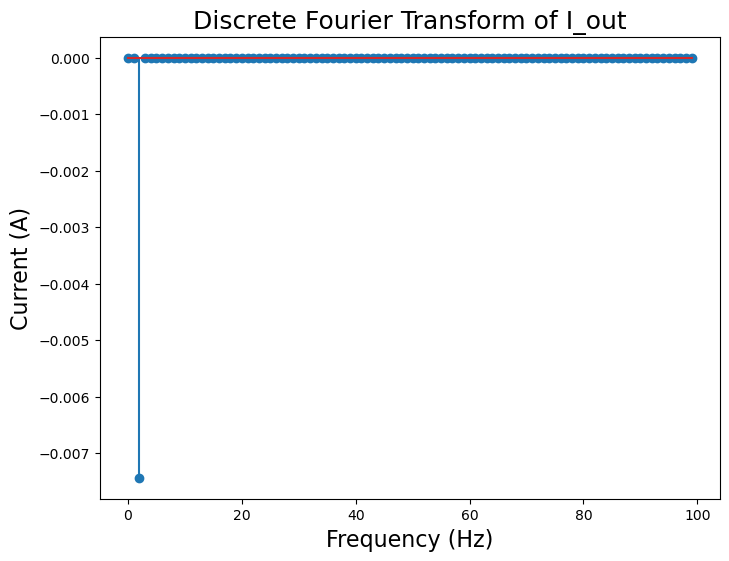

In [733]:
I_out_fft = 2 * np.fft.fft(I_out) / len(I_out)
I_out_fft = I_out_fft[:len(I_out_fft)//2]

I_crit = np.argmax(abs(I_out_fft))
I_amp = I_out_fft[I_crit]

plt.figure(figsize=(8,6))
plt.title("Discrete Fourier Transform of I_out", size=18)
plt.xlabel("Frequency (Hz)", size=16)
plt.ylabel("Current (A)", size=16)
plt.stem(I_out_fft)
print(f"{I_amp=}")
print(I_out_fft[I_crit])

In [734]:
# Z_calc = V_in_amp / I_out_amp
Z_calc = V_in_amp / I_out_fft[I_crit]

complex(-Z_calc.imag, Z_calc.real)

(99.99999999999994-159.15494309189535j)

# Triangle Wave Impedance Analysis

In [735]:
from scipy import signal
import warnings

In [736]:
# Frequency & Amplitude of tri wave
freq = 1000
V_amp = 3.3 / 2

# Desired number of wave oscillations
cycle_num = 10

# Duration of sin wave in seconds
duration = cycle_num / freq 

# Sampling rate of device (samples / sec)
samp_rate = freq * 100

In [737]:
def generate_wave(freq, amp, form="sin", cycle_num=None, duration=None, samp_rate=None):
    """
    Return the time domain t and values  for a wave of given
    FREQUENCY, AMPLITUDE, and STYLE={"sin", "triangle"}
    
    Returns:
    t: Time domain of the generated wave
    vals: Output of the wave function
    
    Example:
    >>> t, V_in = generate_wave(FREQ, AMP, CYCLE_NUM, "sin")
    """
    if duration:
        cycle_num = freq * duration
    elif cycle_num:
        duration = cycle_num / freq
    elif duration and cycle_num and (cycle_num != freq * duration):
        raise ValueError(
            f"{cycle_num} cycles at {freq} cycles per second is incompatible with \
            duration {duration}"
        )
    else:
        raise ValueError('Wave generator requires either "cycle_num" or "duration"')
    
    # Sampling rate of device (samples / sec)
    if not samp_rate:
        warnings.warn("A sampling rate has not been specified; defaulting to 100 samples per cycle")
        samp_rate = freq * 100
    
    # Total number of samples
    samp_num = np.rint(duration * samp_rate)
    
    if form == "sin":
        t = np.arange(0, duration, duration / samp_num)
        vals = amp * np.sin(freq*(2*np.pi*t))
        
    elif form == "triangle":
        t = np.arange(0, 1, 1 / samp_num) * duration
        vals = amp * signal.sawtooth(2*np.pi*cycle_num*np.arange(0, 1, 1 / samp_num), 0.5)
        
    else:
        raise ValueError('Pass in a valid wave form ("sin", "triangle")')
    
    return t, vals

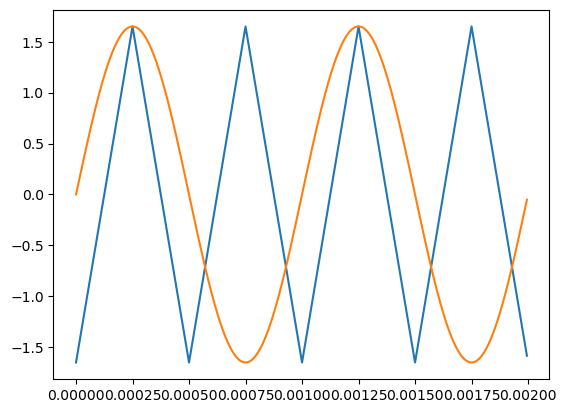

In [738]:
# Sample Usage
t1, V_in1 = generate_wave(2000, 3.3/2, "triangle", duration=0.002, samp_rate=2000*100)
t2, V_in2 = generate_wave(1000, 3.3/2, "sin", cycle_num=2, samp_rate=2000*100)

plt.plot(t1, V_in1)
plt.plot(t2, V_in2)

# Triangle Wave Phase/Amplitude Extraction

In [821]:
freqs = [1000, 2000, 3000]
cycle_num = 5

duration = 1 / min(freqs) * cycle_num
samp_rate = max(freqs) * 100

In [822]:
# Sum multiple triangle waves
t, wave1 = generate_wave(freqs[0], 2, "triangle", duration=duration, samp_rate=samp_rate)
_, wave2 = generate_wave(freqs[1], 1, "triangle", duration=duration, samp_rate=samp_rate)
_, wave3 = generate_wave(freqs[2], 0.25, "triangle", duration=duration, samp_rate=samp_rate)

wave = wave1 + wave2 + wave3

_, unit_wave = generate_wave(1000, 1, "triangle", duration=duration, samp_rate=samp_rate)

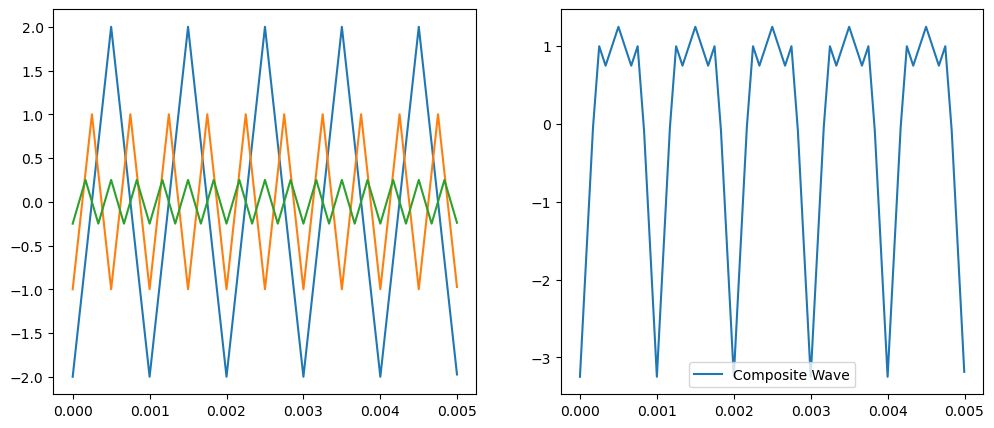

In [823]:
# Plot triangle waves
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(t, wave1, label="Wave 1")
ax[0].plot(t, wave2, label="Wave 2")
ax[0].plot(t, wave3, label="Wave 3")
ax[1].plot(t, wave, label="Composite Wave")
plt.legend()

In [824]:
def phase_shift(wave, shift):
    min_idx, max_idx = np.argmin(wave), np.argmax(wave)
    half_cycle = abs(max_idx - min_idx)
    offset = int(np.rint(half_cycle * shift / np.pi))
    return np.roll(wave, offset)

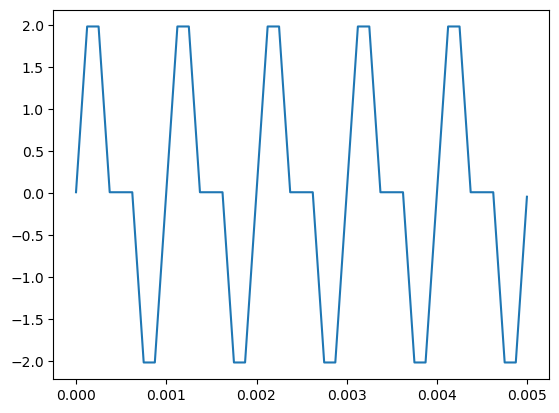

In [825]:
# Create and plot shifted wave
shifted_wave = phase_shift(wave1, np.pi / 2) + phase_shift(wave2, np.pi / 2)
plt.plot(t, shifted_wave)

In [826]:
def ftt(t, wave, freq):
    """
    Similar to the DFT on a sine wave, but modified for use with triangle waves.
    """
    n = wave.size
    dur = t[-1] + t[1]
    samp_rate = n / dur
    _, s_mask = generate_wave(freq, 1, form="triangle", duration=dur, samp_rate=samp_rate)
    c_mask = phase_shift(s_mask, np.pi / 2)
    s_comp = np.dot(s_mask, wave)
    c_comp = np.dot(c_mask, wave)
    res = complex(s_comp, c_comp)
    return res

Dot product: -8.673617379884035e-15, almost zero


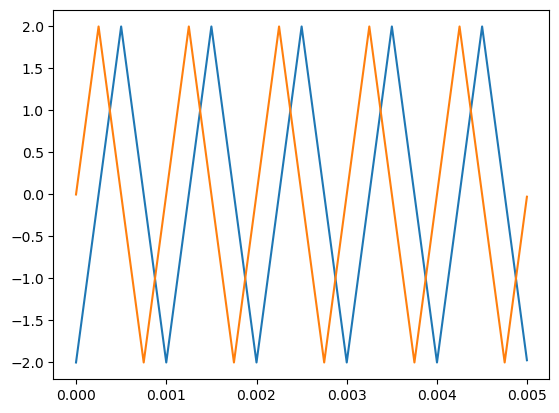

In [827]:
# Demonstrate waves shifted by 90 deg (pi / 2 rad) are orthogonal
plt.plot(t, wave1)
plt.plot(t, phase_shift(wave1, np.pi / 2))
corr = np.dot(wave1, phase_shift(wave1, np.pi / 2))
print(f"Dot product: {corr}, almost zero")

In [828]:
# Triangle transform of 
ftt(t, wave, freqs[0]) * 3 / wave.size

(2.027977777777777+1.1858569681777453e-16j)

In [829]:
Z = ftt(t, shifted_wave, freqs[0]) * 3 / shifted_wave.size
print(f"Output: Amplitude: {abs(Z)}, Phase: {np.angle(Z)}")
print(f"Expected: Amplitude: 2,      Phase: {np.pi/2} = pi / 2")

Output: Amplitude: 2.0001777777777776, Phase: 1.5707963267948966
Expected: Amplitude: 2,      Phase: 1.5707963267948966 = pi / 2


In [830]:
start_cyc = 1

n = t.size
start_idx = start_cyc * n // cycle_num

len(shifted_wave[start_idx:])

1200

In [831]:
# The input for t should start at time t=0

Z = ftt(t[:-start_idx], shifted_wave[start_idx:], 1000) * 3 / shifted_wave[start_idx:].size
print(f"Output: Amplitude: {abs(Z)}, Phase: {np.angle(Z)}")
print(f"Expected: Amplitude: 2,      Phase: {np.pi/2} = pi / 2")

Output: Amplitude: 2.0001777777777776, Phase: -1.5707963267948952
Expected: Amplitude: 2,      Phase: 1.5707963267948966 = pi / 2


# Triangle wave current output

In [893]:
def get_Vr(V0, t, freq, amp, sgn, R, C):
    if sgn == 1:
        a = 4*freq*amp
    else:
        a = -4*freq*amp
    
    B = a*R*C - V0
    return a*R*C - B * np.exp(-t / (R * C))

def get_Vr_out(t, cycle_num, freq, amp, R, C):
    # Values of voltage across resistor
    Vr = np.zeros_like(t)

    # Number of total samples
    n = t.size

    # Number of samples in each rising/falling window
    k = n // cycle_num // 2

    currV = 0
    sgn = 1
    t_slice = t[:k]
    for w in range(cycle_num * 2):
        Vr[w*k:w*k+k] = get_Vr(currV, t_slice, freq, amp, sgn, R, C)
        currV = get_Vr(currV, t[k], freq, amp, sgn, R, C)
        sgn = -sgn
    return Vr

In [970]:
def dual_axis_fig(x, y, title, xtitle, yname, ylabel):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    n = len(y)

    for i in range(n-1):
        # Add traces
        fig.add_trace(
            go.Line(x=x, y=y[i], name=yname[i]),
            secondary_y=False,
        )

        # Set y-axes titles
        fig.update_yaxes(title_text=ylabel[i], secondary_y=False)
    
    # Add traces
    fig.add_trace(
        go.Line(x=x, y=y[n-1], name=yname[n-1]),
        secondary_y=True,
    )

    # Set y-axes titles
    fig.update_yaxes(title_text=ylabel[n-1], secondary_y=True)

    # Add figure title
    fig.update_layout(
        title_text=title
    )

    # Set x-axis title
    fig.update_xaxes(title_text=xtitle, showgrid=True)

    return fig

In [971]:
def I_out_sin(t, freq, I_amp, phase):
    return I_amp * np.sin(freq*(2*np.pi*t) + phase)

In [972]:
def get_V_out(V_in, I_out, Rf):
    V_out = V_in - I_out * Rf
    V_out[V_out > 3.3] = 3.3
    V_out[V_out < -3.3] = -3.3
    return V_out

In [1101]:
def generate_readings(R, C, start_freq, end_freq, cycle_num, form="sin", ex_cyc=0):
    V_amp = 3.3 / 2
    
    freqs = []
    res = []
    curr_freq = start_freq
    while curr_freq <= end_freq:
        if form == "sin":
            freqs.append(curr_freq)
            w = 2 * np.pi * curr_freq
            Z = complex(R, -1/(w*C))

            t, V_in = generate_wave(curr_freq, V_amp, form, cycle_num=cycle_num)
            phase = np.angle(- (V_amp / Z))
            I_amp = V_amp / abs(Z)

            I_out = I_out_sin(t, curr_freq, I_amp, phase)
            
            I_out_fft = 2 * np.fft.fft(I_out) / len(I_out)
            I_out_fft = I_out_fft[:len(I_out_fft)//2]
            I_crit = np.argmax(abs(I_out_fft))
            
            
            Z_calc = V_amp / I_out_fft[I_crit]
            Z_calc = complex(-Z_calc.imag, Z_calc.real)
            res.append(Z_calc)
            
        
        if form == "triangle":
            freqs.append(curr_freq)
            
            t, V_in = generate_wave(curr_freq, V_amp, form, cycle_num=cycle_num)
            Vr = get_Vr_out(t, cycle_num, freq, V_amp, R, C)
            I_out = Vr / R
            
            n = V_in.size
            if not ex_cyc: ex_cyc = cycle_num - 10
            start_idx = int(np.rint(ex_cyc * n / cycle_num))
            
            I_out_dft = ftt(t[:-start_idx], I_out[start_idx:], 1000) * 3 / I_out[start_idx:].size
            Z_tri = V_amp / I_out_dft
            
            res.append(Z_tri)
        
        curr_freq *= 2
    
    return freqs, res
        

In [1102]:
# Frequency & Amplitude of tri wave
freq = 100
V_amp = 3.3 / 2

# Desired number of wave oscillations
cycle_num = 10

# Duration of sin wave in seconds
duration = cycle_num / freq 

# Sampling rate of device (samples / sec)
samp_rate = freq * 100

# Resistor and Capacitor Values
R = 80000
C = 1e-7

period = 1 / freq

In [1103]:
print(f"{cycle_num=}")
print(f"{duration=}")
print(f"{samp_rate=}")
print(f"{freq=}")
print(f"{V_amp=}")
print(f"{R=}")
print(f"{C=}")
print(f"{Rf=}")

cycle_num=10
duration=0.1
samp_rate=10000
freq=100
V_amp=1.65
R=80000
C=1e-07
Rf=1000


In [1104]:
# Generate V_in based on params
t, V_in = generate_wave(freq, V_amp, "triangle", cycle_num=cycle_num, samp_rate=samp_rate)

In [1105]:
# Generate Vr based on V_in
Vr = get_Vr_out(t, cycle_num, freq, V_amp, R, C)

In [1106]:
# Generate I_out and V_c based on Vr
I_out = -Vr / R
V_c = V_in - Vr

In [1107]:
dual_axis_fig(t, [V_in, V_c, I_out], 
                                "Triangle Wave Circuit Readings", "Time",
                                ["V_in", "V_c", "I_out"],
                                ["Volts", "Volts", "Amps"])

In [1108]:
def digitize(wave, num_levels):
    V_amp = 1.65
    
    levels = 2 * V_amp * np.arange(num_levels + 1) / num_levels
    return np.digitize(wave, levels) * (2 * V_amp / num_levels)
    

# Apply Triangle Transform to I_out

In [1109]:
# Calculate phase and amplitude of I_out at freq of V_in
start_cyc = 9

n = V_in.size
start_idx = start_cyc * n // cycle_num

I_out_dft = ftt(t[:-start_idx], I_out[start_idx:], freq) * 3 / len(I_out[start_idx:])

In [1110]:
# Calculate expected impedance based on sine input
w = 2*np.pi*freq
Z = complex(R, -1/(w*C))
print(f"This is only defined for sine waves!")
print(f"Expected: Phase: {np.angle(Z)}, Amplitude: {abs(Z)}")

This is only defined for sine waves!
Expected: Phase: -0.1963796604316659, Amplitude: 81567.7813790828


In [1111]:
# Generate our "triangular impedance" based on triangle wave input
Z_tri = V_amp / I_out_dft
print(f"Output: Phase: {np.angle(Z_tri)}, Amplitude: {abs(Z_tri)}")

Output: Phase: -2.948920536638805, Amplitude: 81518.81039673297


# Generate Freq-Impedance at one Capacitance Value

In [1112]:
def plot_rows(M, x, y, xlabel, ylabel, title, legend_name, alpha=1,):
    cm = plt.get_cmap('gist_rainbow')

    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    m = M.shape[0]
    ax.set_prop_cycle(color=[cm(1.*i/m) for i in range(m)])

    for i in range(m):
        plt.plot(x, M[i], label=legend_name + " = " + str(y[i]), alpha=alpha)

    ax.legend(bbox_to_anchor=(1.01, 1),
                             loc='upper left', borderaxespad=0., ncol=1)
    ax.set_title(title, size=24)
    ax.set_xlabel(xlabel, size=18)
    ax.set_ylabel(ylabel, size=18)

In [1113]:
# Generate impedances at various frequencies
freqs, Z = generate_readings(R=80000, C=1e-9, start_freq=100, end_freq=10_000_000, cycle_num=20000, form="sin",
                            ex_cyc=20000-1)

Z = np.array(Z)

/var/folders/7f/0dmn96gx30j02w6vjwjw84xc0000gn/T/ipykernel_82340/4087511204.py:27: UserWarning:

A sampling rate has not been specified; defaulting to 100 samples per cycle



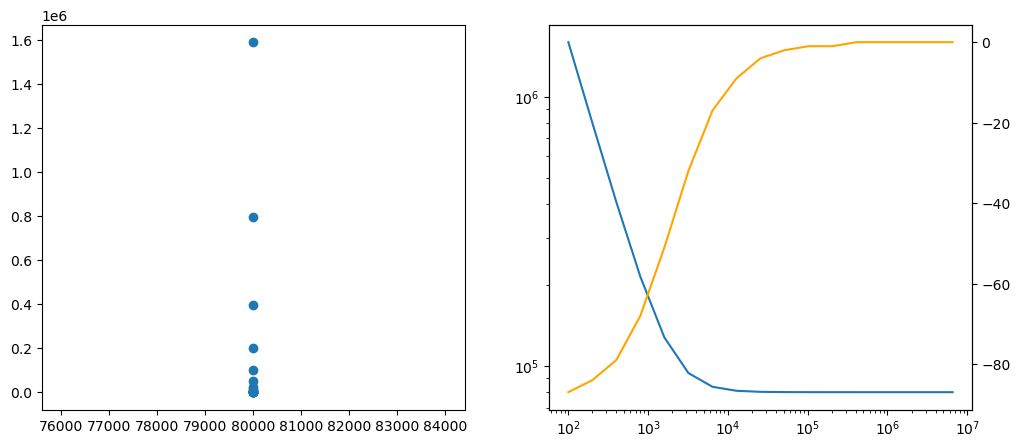

In [1114]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(np.rint(Z.real), np.rint(-Z.imag))

deg = np.angle(Z) / (2 * np.pi) * 360
ax[1].plot(freqs, abs(Z))
ax2 = ax[1].twinx()
ax2.plot(freqs, np.rint(np.angle(Z) / (2 * np.pi) * 360), color="orange")


ax[1].set_xscale("log")
ax[1].set_yscale("log")



In [1115]:
# Generate impedances at various frequencies, one frequency-impedance list for each capacitance value
# C_vals = [1.25**p for p in range(-9, 0, 1)]
C_vals = [a * 1e-6 for a in range(1, 10, 1)]

Z_vals = []
for C in tqdm(C_vals):
    freqs, Z = generate_readings(R=80000, C=C, start_freq=100, end_freq=10_000_000, cycle_num=20000, 
                                 form="triangle", ex_cyc=20000-1)
    Z_vals.append(Z)

  0%|                                             | 0/9 [00:00<?, ?it/s]/var/folders/7f/0dmn96gx30j02w6vjwjw84xc0000gn/T/ipykernel_82340/4087511204.py:27: UserWarning:

A sampling rate has not been specified; defaulting to 100 samples per cycle

100%|█████████████████████████████████████| 9/9 [01:13<00:00,  8.15s/it]


In [1118]:
Z_vals = np.array(Z_vals)
abs(Z_vals)

array([[5.65341693e+19, 3.92157647e+06, 8.98254415e+06, 6.19575467e+05,
        1.70027612e+06, 9.81403743e+07, 3.89341819e+08, 1.55100690e+09,
        6.17714959e+09, 1.32359302e+09, 2.26201115e+08, 1.32170360e+08,
        1.42884054e+08, 2.10100674e+08, 3.60300812e+08, 6.67266578e+08,
        1.28419654e+09],
       [4.65357796e+19, 3.92157059e+06, 9.06374197e+06, 6.19581418e+05,
        1.69912622e+06, 9.73354546e+07, 3.87751726e+08, 1.54709778e+09,
        6.86259952e+08, 1.15374470e+08, 6.67366736e+07, 7.17907467e+07,
        1.05305476e+08, 1.80368644e+08, 3.33835130e+08, 6.42292382e+08,
        1.25993515e+09],
       [7.75573931e+19, 3.92156950e+06, 9.09117273e+06, 6.19583715e+05,
        1.69874344e+06, 9.70700775e+07, 3.87224541e+08, 1.20422212e+09,
        1.35591481e+08, 5.11319927e+07, 4.44277379e+07, 5.85751309e+07,
        9.51203305e+07, 1.71424242e+08, 3.25452519e+08, 6.34177129e+08,
        1.25194925e+09],
       [2.70388912e+19, 3.92156912e+06, 9.10495742e+06, 6.195

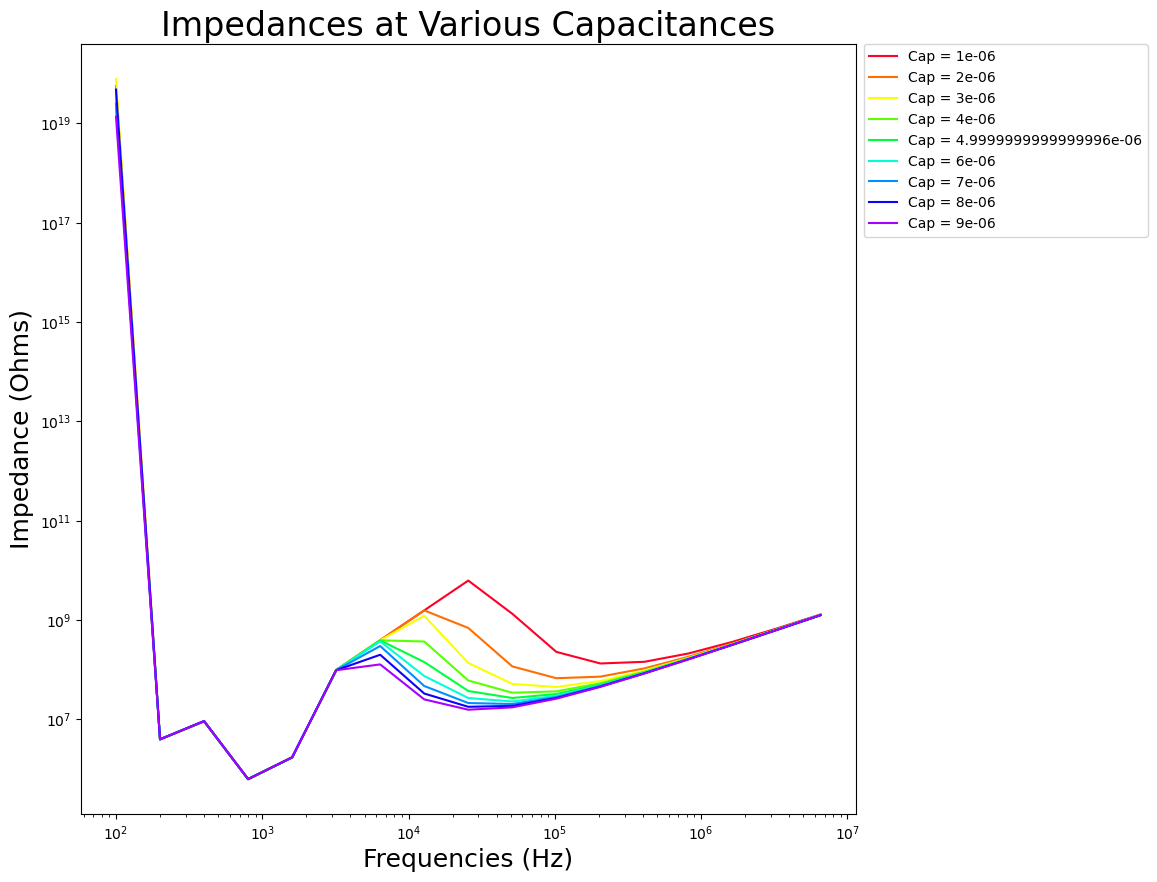

In [1119]:
plot_rows(abs(Z_vals), freqs, C_vals, xlabel="Frequencies (Hz)",
          ylabel="Impedance (Ohms)", title="Impedances at Various Capacitances", 
          legend_name="Cap", alpha=1,)

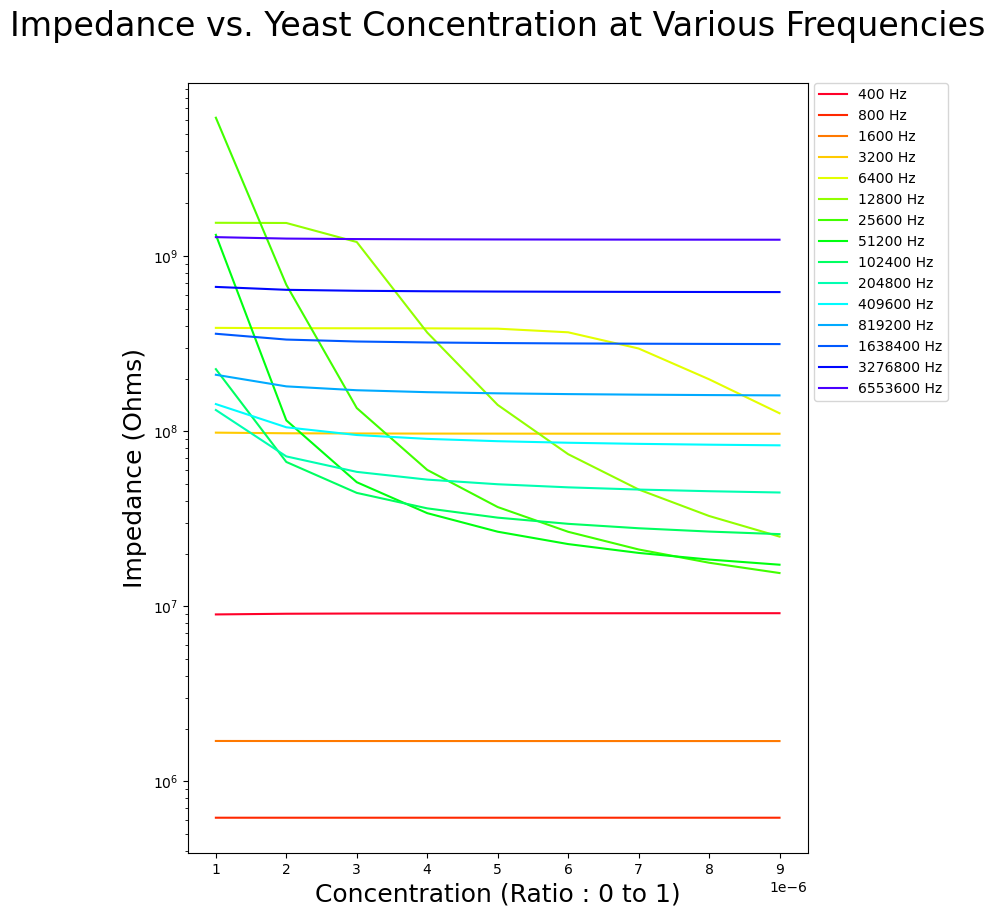

In [1120]:
cm = plt.get_cmap('gist_rainbow')
fig, ax = plt.subplots(1, figsize=(8,10))

# ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Concentration (Ratio : 0 to 1)", size=18)
ax.set_ylabel("Impedance (Ohms)", size=18)
ax.set_title("Impedance vs. Yeast Concentration at Various Frequencies", size=24, y=1.05)
ax.set_prop_cycle(color=[cm(1.*i/len(freqs)) for i in range(len(freqs))])

for i in range(2, len(freqs)): 
#     ax[0].plot(concentrations, Z[:,i], label=str(freqs[i])+" Hz")
    ax.plot(C_vals, abs(Z_vals[:,i]), label=str(freqs[i])+" Hz")
ax.legend(bbox_to_anchor=(1.01, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()